# Load & Merge data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost and CatBoost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
email_df = pd.read_csv('/kaggle/input/email-campaign/email_table.csv')
opened_df = pd.read_csv('/kaggle/input/email-campaign/email_opened_table.csv')
clicked_df = pd.read_csv('/kaggle/input/email-campaign/email_opened_table.csv')

In [3]:
# Add binary target labels
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

# Exploratory Data Analysis (EDA)

## 1. Basic Email Campaign Metrics

In [4]:
# total_emails = len(email_df)
# opened_pct = email_df['opened'].mean() * 100
# clicked_pct = email_df['clicked'].mean() * 100
# ctr = clicked_pct # Click-Through Rate

# print(f"Open Rate: {opened_pct:.2f}%")
# print(f"Click-Through Rate (CTR): {clicked_pct:.2f}%")

print("Total emails sent:", len(email_df))
print("Opened rate: {:.2f}%".format(email_df['opened'].mean() * 100))
print("Clicked rate: {:.2f}%".format(email_df['clicked'].mean() * 100))

Total emails sent: 100000
Opened rate: 10.35%
Clicked rate: 10.35%


- **Open Rate (10.35%)** is quite low – typically, average open rates vary by industry, but many aim for at least 20–25%.

- **Click Rate (10.35%)** exactly matches the open rate, which is unusual – it implies every person who opened the email also clicked, which is rare and could be:

    -> True if the email was highly compelling.

    -> Or due to data recording issues (e.g., missing events, or conflated metrics).

## 2. Click/Opened Distribution

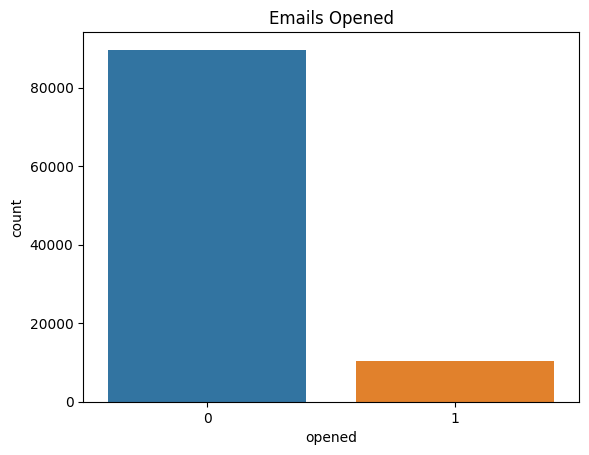

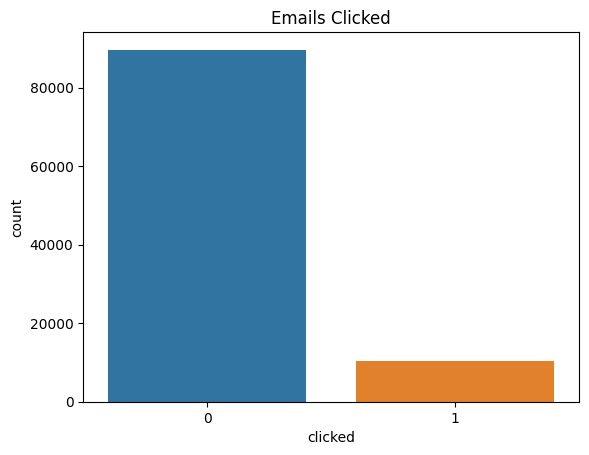

In [5]:
sns.countplot(data=email_df, x='opened')
plt.title("Emails Opened")
plt.show()

sns.countplot(data=email_df, x='clicked')
plt.title("Emails Clicked")
plt.show()

## 3. CTR by email version & Text Type

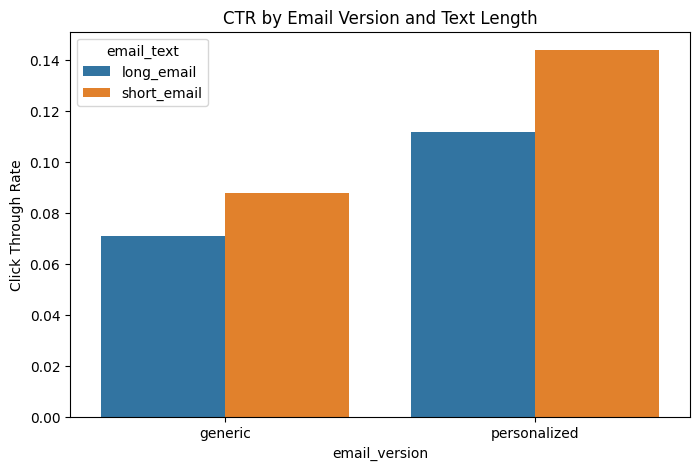

In [6]:
# CTR by version
version_text_ctr = email_df.groupby(['email_version', 'email_text'])['clicked'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=version_text_ctr, x='email_version', y='clicked', hue='email_text')
plt.title("CTR by Email Version and Text Length")
plt.ylabel("Click Through Rate")
plt.show()

1. Personalization Improves CTR

- Both long and short personalized emails outperform their generic counterparts.

- This confirms that personalization is a strong positive driver of user engagement.

2. Short Emails Perform Better than Long Emails

- Within each version (generic or personalized), short emails have higher CTR.

- Users may prefer concise messaging, leading to more engagement.

3. Best Performing Combo

- Short + Personalized emails have the highest CTR (~14.5%)

- This combo should be prioritized in future campaigns.

4. Worst Performing Combo

- Long + Generic emails have the lowest CTR (~7%)

- These could be reduced or removed from future efforts.

## 4. Clicks by Hour of Send

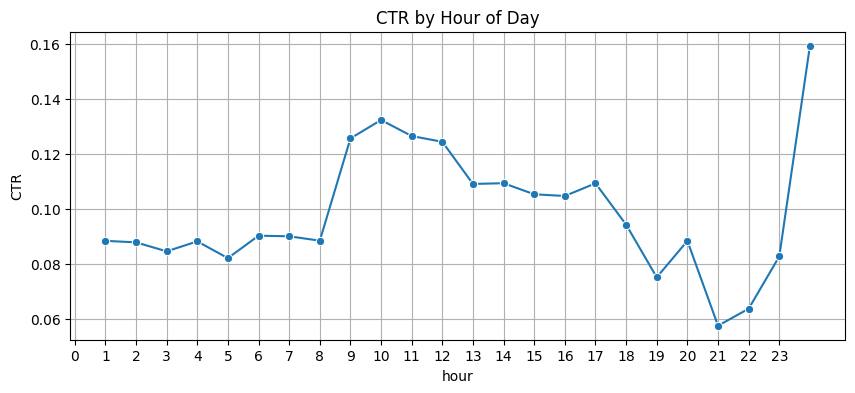

In [7]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=email_df.groupby('hour')['clicked'].mean().reset_index(), x='hour', y='clicked', marker='o')
plt.title("CTR by Hour of Day")
plt.ylabel("CTR")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

1. Early Morning (0–8 AM)

- CTR is relatively flat and low (around 8.5–9%).

- Possibly due to users not checking email overnight or being less responsive.

2. Morning Spike (9–12 PM)

- Big jump starting at 9 AM (~12.5%) peaking around 10 AM at ~13.5%.

- This is a prime engagement window—people often check emails around start of workday.

3. Afternoon Stability (13–17)

- CTR stabilizes around 11–11.5%, still strong but slightly lower than late morning.

4. Evening Drop (18–21)

- Noticeable decline, hitting a low around 21:00 (~5.8%).

- Users may be less engaged with promotional content during this time.

5. Late Night Spike (23:00)

- Surprising peak to ~16%, the highest CTR of the day.

- Might indicate a small but highly engaged late-night user segment.

## 5. User Country Impact

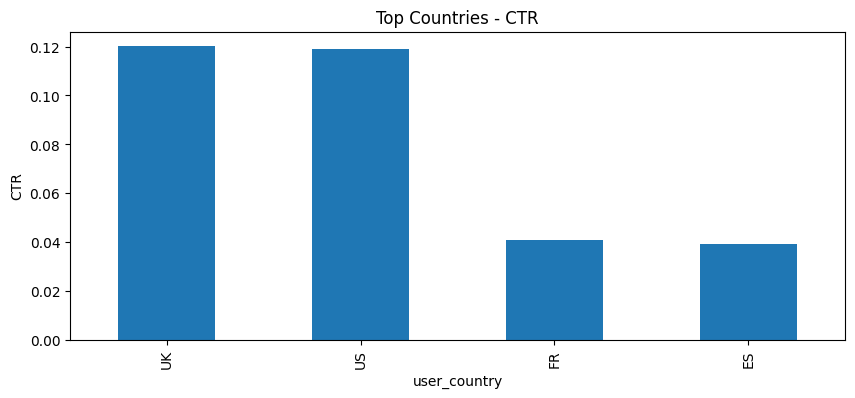

In [8]:
top_countries = email_df['user_country'].value_counts().head(10).index
country_ctr = email_df[email_df['user_country'].isin(top_countries)].groupby('user_country')['clicked'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 4))
country_ctr.plot(kind='bar')
plt.title("Top Countries - CTR")
plt.ylabel("CTR")
plt.show()

## 6. Past purchases vs CTR

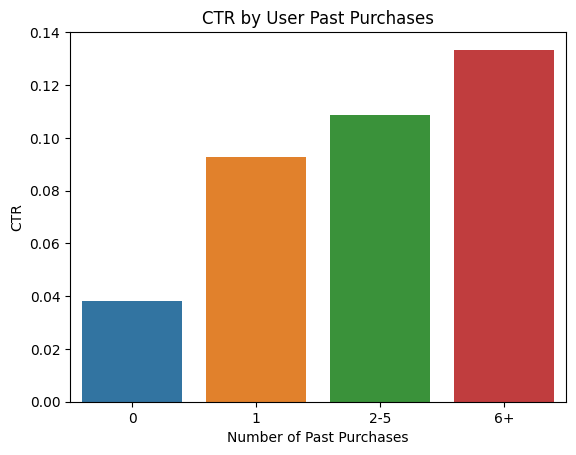

In [9]:
email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=[-1, 0, 1, 5, 100], labels=['0', '1', '2-5', '6+'])

purchase_ctr = email_df.groupby('purchase_bin')['clicked'].mean().reset_index()

sns.barplot(data=purchase_ctr, x='purchase_bin', y='clicked')
plt.title("CTR by User Past Purchases")
plt.xlabel("Number of Past Purchases")
plt.ylabel("CTR")
plt.show()

## 7. Univariate Analysis

### a. Histograms for Numerical Features

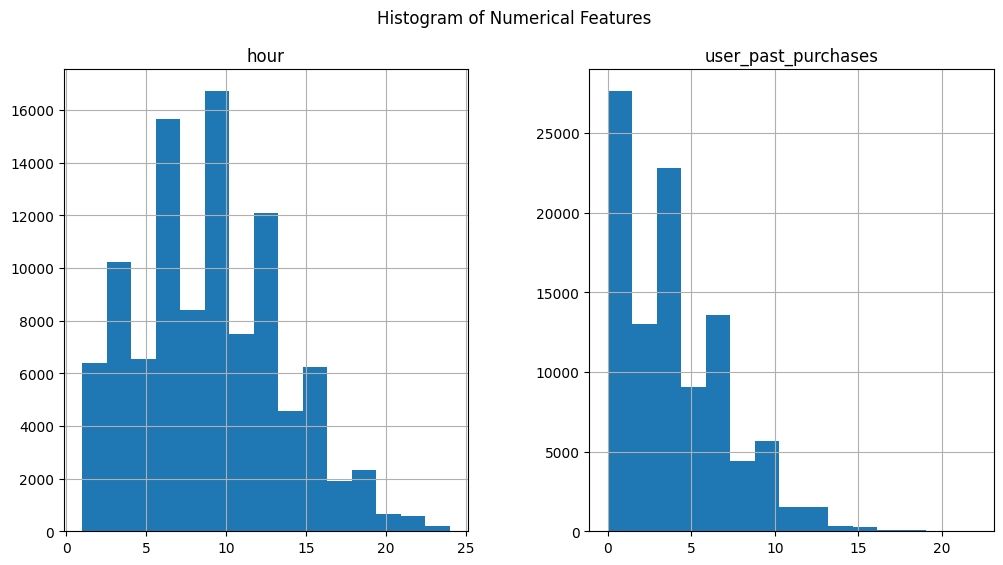

In [10]:
numerical_features = ['hour', 'user_past_purchases']
email_df[numerical_features].hist(bins=15, figsize=(12, 6))
plt.suptitle('Histogram of Numerical Features')
plt.show()

1. Distribution of hour
- This represents the distribution of email sending times over 24 hours.

- Peaks around 4–5, 7–8, and 10–11 hours: These are the most common hours emails were sent.

- Low volume in late evening and night hours (after 17:00).

Insight:
The majority of emails were sent during early to mid-morning hours, which coincides well with the earlier chart where we saw higher CTR during those times. However, hours with fewer emails (like 23:00) showed very high CTR — hinting at underutilized high-CTR slots.

2. Distribution of user_past_purchases
- Very right-skewed distribution: most users have made 0 to 5 purchases.

- A small segment of users has made 10+ purchases.

Insight:
This indicates that the majority of users are either new or infrequent buyers. However, those with higher past purchases might behave differently — likely more engaged or loyal. Segmenting users by past purchase behavior could help optimize targeting.

### b. Boxplots for Numerical Features

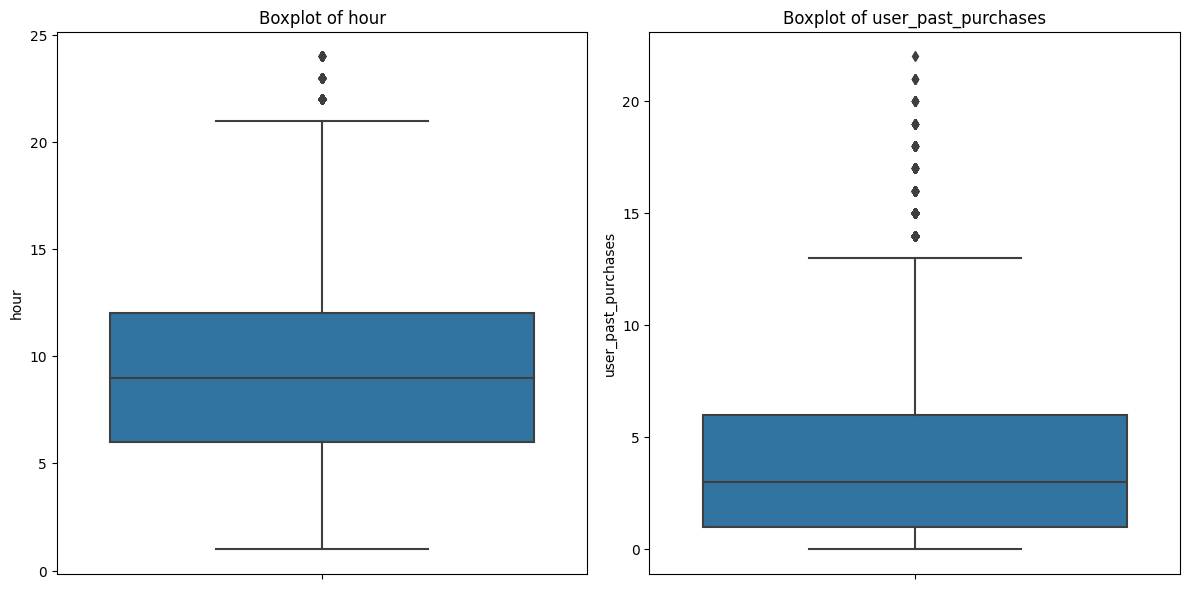

In [11]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=email_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

## 8. Bivariate Analysis

### a. Click Rate by Email Version

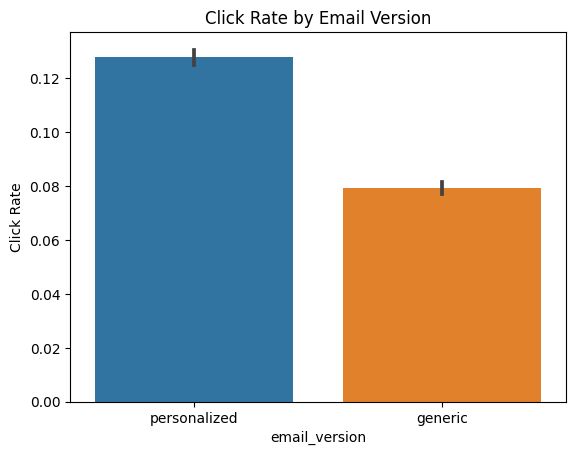

In [12]:
sns.barplot(x='email_version', y='clicked', data=email_df)
plt.title('Click Rate by Email Version')
plt.ylabel('Click Rate')
plt.show()

### b. Click Rate by Email Text

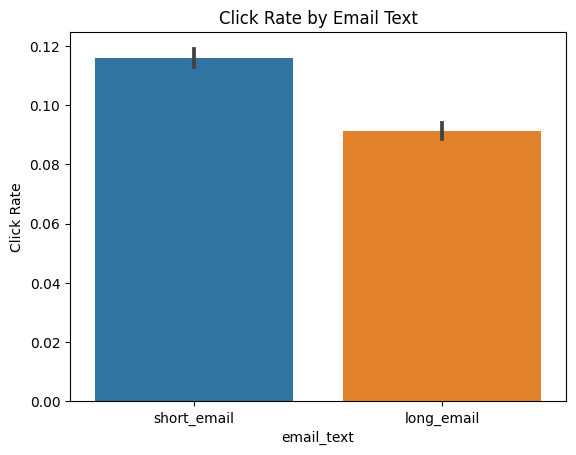

In [13]:
sns.barplot(x='email_text', y='clicked', data=email_df)
plt.title('Click Rate by Email Text')
plt.ylabel('Click Rate')
plt.show()

### c. Click Rate by Weekday

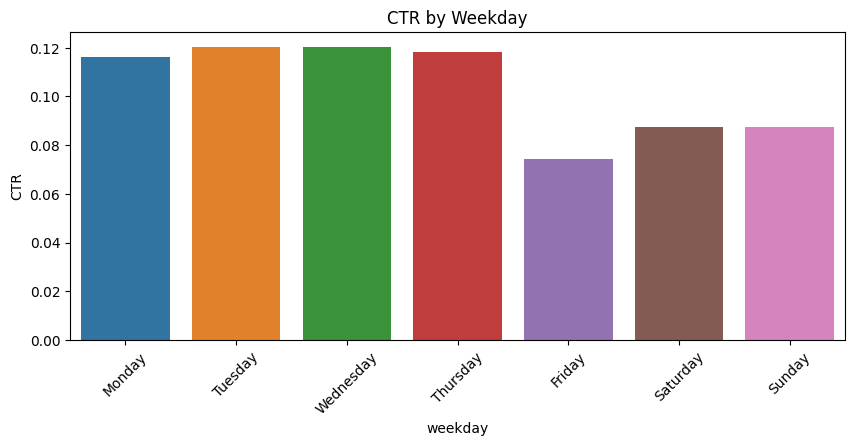

In [14]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_ctr = email_df.groupby('weekday')['clicked'].mean().reindex(weekday_order).reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=weekday_ctr, x='weekday', y='clicked')
plt.title("CTR by Weekday")
plt.ylabel("CTR")
plt.xticks(rotation=45)
plt.show()

## 9. Pairplot Analysis

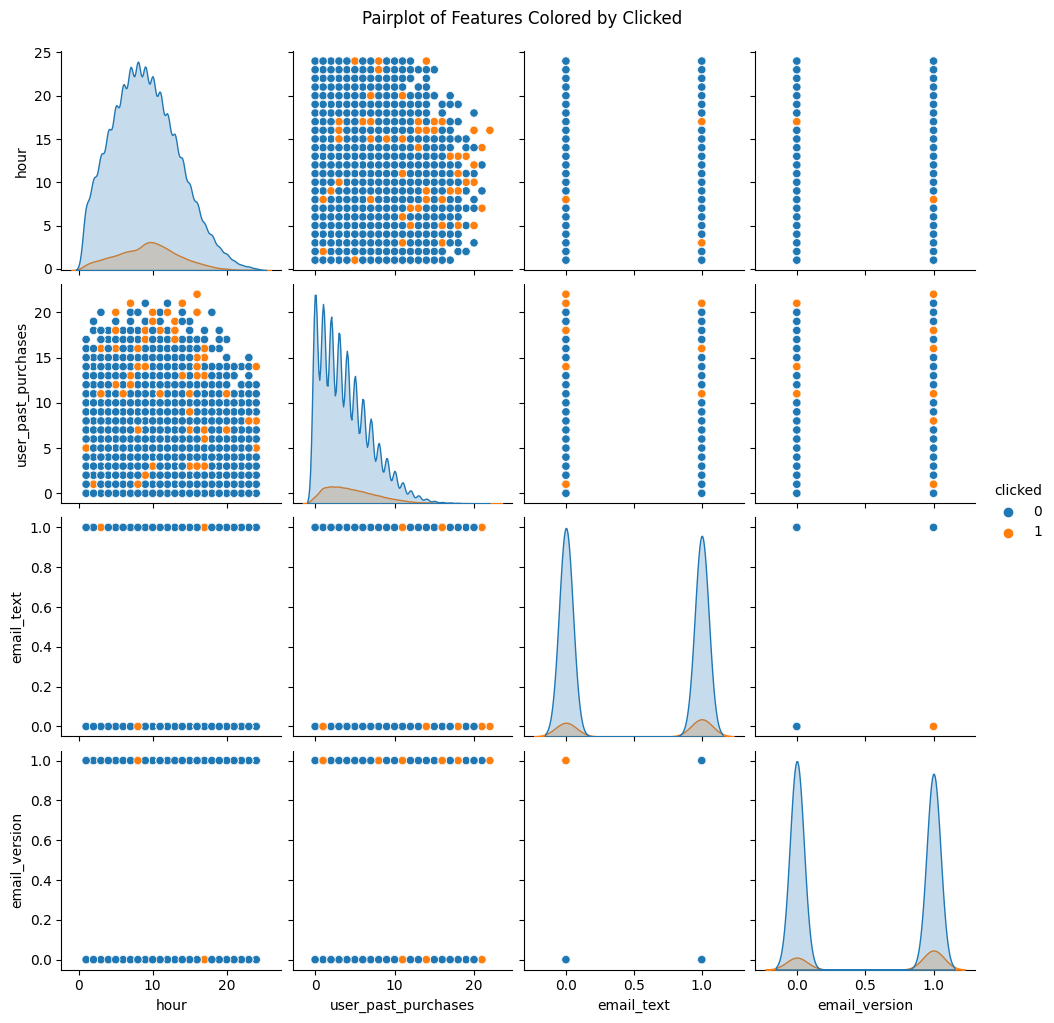

In [15]:
# Encode categorical variables for pairplot
pairplot_df = email_df.copy()
le = LabelEncoder()
pairplot_df['email_text'] = le.fit_transform(pairplot_df['email_text'])
pairplot_df['email_version'] = le.fit_transform(pairplot_df['email_version'])
pairplot_df['user_country'] = le.fit_transform(pairplot_df['user_country'])
pairplot_df['weekday'] = le.fit_transform(pairplot_df['weekday'])

sns.pairplot(pairplot_df[['hour', 'user_past_purchases', 'email_text', 'email_version', 'clicked']], hue='clicked')
plt.suptitle('Pairplot of Features Colored by Clicked', y=1.02)
plt.show()

## 10. Correlation Heatmap

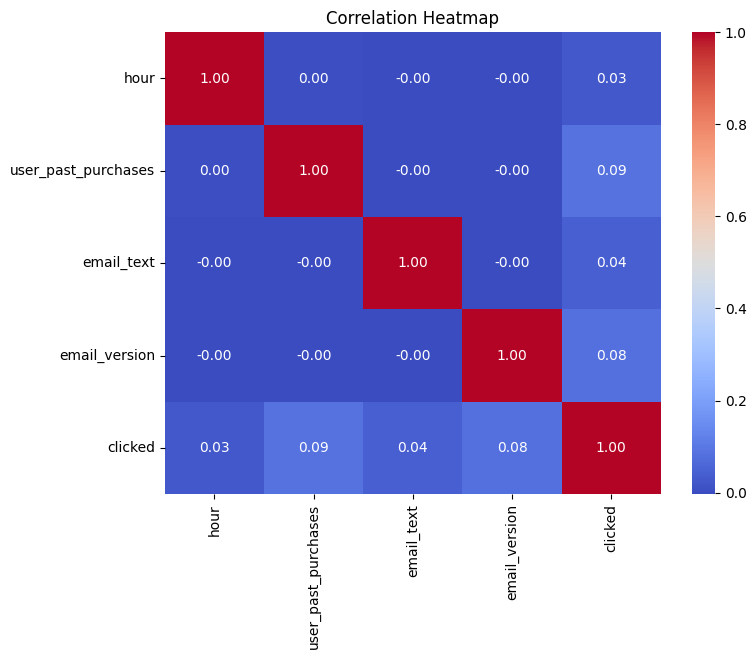

In [16]:
corr = pairplot_df[['hour', 'user_past_purchases', 'email_text', 'email_version', 'clicked']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Train a Model to Predict Clicks

In [17]:
# prepare features
features = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
X = email_df[features]
y = email_df['clicked']

In [18]:
# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
# # Identify categorical feature names
# cat_features = ['email_text', 'email_version', 'weekday', 'user_country']
# Before one-hot encoding, save raw data
X_raw = email_df[features]
cat_features = ['email_text', 'email_version', 'weekday', 'user_country']

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [20]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# # Train a Random Forest
# rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_clf.fit(X_train, y_train)

In [22]:
# # Predict probabilities
# y_pred_prob = rf_clf.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_pred_prob)
# print(f"ROC-AUC for click prediction: {roc_auc:.4f}")

In [23]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "KNN Ensemble": BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=10, random_state=42),
    "Neural Network": MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=(10,)),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(random_state=42, iterations=100, learning_rate=0.14, depth=6, verbose=0)
}

In [24]:
best_model_name = None
best_model = None
best_auc = 0

model_performance = {}

for name, model in models.items():
    if name in ["Support Vector Machine", "K-Nearest Neighbors", "KNN Ensemble", "Neural Network"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    elif name=="CatBoost":
        model.fit(X_train_raw, y_train_raw, cat_features=cat_features)
        y_pred = model.predict(X_test_raw)
        y_proba = model.predict_proba(X_test_raw)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    model_performance[name] = {'Accuracy': acc, 'ROC AUC': auc}
    print(f"{name} - Accuracy: {acc:.4f}, ROC AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_model = model

print(f"\n Best Model: {best_model_name} (ROC AUC = {best_auc:.4f})")

Logistic Regression - Accuracy: 0.8954, ROC AUC: 0.6745
Random Forest - Accuracy: 0.8792, ROC AUC: 0.6002
Gradient Boosting - Accuracy: 0.8953, ROC AUC: 0.6855
Support Vector Machine - Accuracy: 0.8954, ROC AUC: 0.5501
K-Nearest Neighbors - Accuracy: 0.8843, ROC AUC: 0.5731
KNN Ensemble - Accuracy: 0.8886, ROC AUC: 0.6058
Neural Network - Accuracy: 0.8954, ROC AUC: 0.6723
XGBoost - Accuracy: 0.8954, ROC AUC: 0.6815
CatBoost - Accuracy: 0.8953, ROC AUC: 0.6784

 Best Model: Gradient Boosting (ROC AUC = 0.6855)


- **Accuracy is similar (~0.89)** across models, which likely reflects class imbalance (majority class dominates).

- **ROC AUC helps differentiate** models better for imbalanced datasets — Gradient Boosting, XGBoost, and CatBoost are close contenders.

- **SVM has high accuracy but very low ROC AUC** → not distinguishing well between classes.

- **Ensemble techniques (GBM, XGB, CatBoost)** outperform basic models on AUC.



# Estimate Click-Through Rate Improvement

In [25]:
# # predict on entire dataset
# email_df['click_prob'] = rf_clf.predict_proba(X_encoded)[:, 1]

In [26]:
# # Sort by predicted probability
# email_df_sorted = email_df.sort_values(by='click_prob', ascending=False)

In [27]:
# # Simulate sending top N% of emails based on model
# top_n = int(0.2 * total_emails) # sending to top 20% most likely to click
# model_based_ctr = email_df_sorted.head(top_n)['clicked'].mean() * 100

In [28]:
# print(f"Model-based CTR on top 20%: {model_based_ctr: .2f}%")
# print(f"Relative improvement: {(model_based_ctr - ctr):.2f}% over random sending")

In [29]:
baseline_ctr = email_df['clicked'].mean()
print(f"Baseline CTR (random targeting): {baseline_ctr:.4f}")

Baseline CTR (random targeting): 0.1035


In [30]:
# Get predicted probabilities
y_proba_all = best_model.predict_proba(X_encoded)[:, 1]

# Add back to original dataframe
email_df['predicted_proba'] = y_proba_all

# Simulating targeting top X% of users
top_x_percent = 0.2 # Try 20% likely users
top_users = email_df.sort_values(by='predicted_proba', ascending=False).head(int(len(email_df) * top_x_percent))

model_ctr = top_users['clicked'].mean()
print(f"Model-targeted CTR: {model_ctr:.4f}")

Model-targeted CTR: 0.1974


In [31]:
improvement = ((model_ctr-baseline_ctr) / baseline_ctr) * 100
print(f"Estimated improvement in CTR: {improvement:.2f}%")

Estimated improvement in CTR: 90.82%


**ROI Implication (Hypothetical)**
If we assume:

- 100,000 emails sent,

- Original clicks ≈ 10,350 (10.35%),

- Targeted clicks ≈ 19,740 (19.74%),

Then we are potentially gaining ~9,390 more clicks just by using model-based targeting. That’s a huge uplift in engagement — especially if clicks correlate with revenue.

# Segment Analysis: Patterns in Performance

In [32]:
# Analyze by email version
version_perf = email_df.groupby('email_version')['clicked'].mean().reset_index()
print("Click Rate by Email Version:")
print(version_perf)

# Analyze by weekday
weekday_perf = email_df.groupby('weekday')['clicked'].mean().reset_index()
print("Click Rate by Weekday:")
print(weekday_perf)

# Analyze by user past purchase buckets
email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=[-1, 0, 1, 5, 100], labels=['0', '1', '2-5', '6+'])
purchase_perf = email_df.groupby('purchase_bin')['clicked'].mean().reset_index()
print("Click Rate by Past Purchases:")
print(purchase_perf)

Click Rate by Email Version:
  email_version   clicked
0       generic  0.079348
1  personalized  0.127754
Click Rate by Weekday:
     weekday   clicked
0     Friday  0.074134
1     Monday  0.116062
2   Saturday  0.087652
3     Sunday  0.087649
4   Thursday  0.118442
5    Tuesday  0.120484
6  Wednesday  0.120278
Click Rate by Past Purchases:
  purchase_bin   clicked
0            0  0.038337
1            1  0.092793
2          2-5  0.108513
3           6+  0.133399
